In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os 
from os import path
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


%matplotlib inline

def colorselection(image,low,high):
    hsv=cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, low, high) 
    return cv2.bitwise_and(image,image, mask= mask)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    x1left=x2left=x1right=x2right=0.0
    y1left=y1right=y2left=y2right=0.0
    nblineleft=nblineright=1.0

    for line in lines:
        for x1,y1,x2,y2 in line:
            angle = (np.rad2deg(np.arctan2(y1 - y2, x1 - x2)))
            #print(line)
            if (angle>=120.0 and angle<=150.0):
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                x1left+=x1
                x2left+=x2
                y1left+=y1
                y2left+=y2
                nblineleft+=1
            elif (angle<-120.0 and angle>-150):
                #right.append((x1,y1,x2,y2,xbottom))
                x1right+=x1
                x2right+=x2
                y1right+=y1
                y2right+=y2
                nblineright+=1
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    #print(nblineright)
    #print(nblineleft)
    
    #Lines Average
    if(nblineright>1):
        nblineright-=1
        x1right=math.ceil(x1right/nblineright)
        x2right=math.ceil(x2right/nblineright)
        y1right=math.ceil(y1right/nblineright)
        y2right=math.ceil(y2right/nblineright)
    if(nblineleft>1):
        nblineleft-=1
        x1left=math.ceil(x1left/nblineleft)
        x2left=math.ceil(x2left/nblineleft)
        y1left=math.ceil(y1left/nblineleft)
        y2left=math.ceil(y2left/nblineleft)
    '''
    print(x1left)
    print(y1left)
    print(x2left)
    print(y2left)
    '''
    #Line Extrapolation
    if(nblineleft>1):
        slope,intercept=line_properties(x1left,y1left,x2left,y2left)
        y1left=img.shape[0]
        x1left=math.ceil(solve_for_x(y1left,slope,intercept))
        y2left=math.ceil((img.shape[0]/2)+80)
        x2left=math.ceil(solve_for_x(y2left,slope,intercept))
        cv2.line(img, (x1left, y1left), (x2left, y2left), color, thickness)
    
    if(nblineright>1):
        slope,intercept=line_properties(x1right,y1right,x2right,y2right)
        y1right=img.shape[0]
        x1right=math.ceil(solve_for_x(y1right,slope,intercept))
        y2right=math.ceil((img.shape[0]/2)+80)
        x2right=math.ceil(solve_for_x(y2right,slope,intercept))
        cv2.line(img, (x1right, y1right), (x2right, y2right), color, thickness)  
    
    
    #cv2.line(img, (x1left, y1left), (x2left, y2left), color, thickness)
    #cv2.line(img, (x1right, y1right), (x2right, y2right), color, thickness)
    return               

def solve_for_y(x, slope, intercept):
    '''Solve for Y cord using line equation'''
    if slope != None and intercept != None:
            return float(slope) * x + float(intercept)
    else:
            raise Exception('Can not solve on a vertical line')

def solve_for_x(y, slope, intercept):
    '''Solve for X cord using line equatio'''
    if slope != 0 and slope:
            return float((y - float(intercept))) / float(slope)
    else:
            raise Exception('Can not solve on a horizontal line')
            
def line_properties(x1,y1,x2,y2):
    #slope = (x2-x1)/(y2-y1)
    #intercept =y1-(slope*x1)
    try:
        slope=(float(y2)-y1)/(float(x2)-x1)
    except ZeroDivisionError:
        # line is vertical
        slope=None
    if slope != None:
        intercept= y2 - slope * x2
    else:
        intercept= None    
    return slope,intercept
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    color=(255, 0, 0)
    draw_lines(line_img, lines,color,14)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def colorselection(image,low,high):
    hsv=cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, low, high) 
    return cv2.bitwise_and(image,image, mask= mask)

def process_image(path):
    if type(path) == str :
        image = mpimg.imread(path)
    else :
        image = path
    #image = mpimg.imread('test_images/solidYellowLeft.jpg')
    #Color selection
    #white = cv2.inRange(image, (0, 0, 180), (255, 25, 255)) 
    #yellow = cv2.inRange(image, (20, 80, 80), (50, 255, 255))

    low_threshold=np.array([0,0,200])
    high_threshold=np.array([255,25,255])
    white = colorselection(image,low_threshold,high_threshold)
    #plt.figure()
    #plt.imshow(white)


    #image = mpimg.imread('test_images/solidYellowLeft.jpg')
    low_threshold=np.array([20,100,100])
    high_threshold=np.array([50,255,255])
    yellow = colorselection(image,low_threshold,high_threshold)
    #plt.figure()
    #plt.imshow(yellow)

    add = cv2.add(yellow,white)
    #plt.figure()
    #plt.imshow(add)
    #grayimg = grayscale(image)
    #plt.imshow(grayimg, cmap='gray')

    #Smoothing the image with gaussian noise using correlation
    #kernel_size=3
    #blurgrayimg = gaussian_blur(grayimg, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 100
    high_threshold = 250

    cnedges=canny(add,low_threshold,high_threshold)
    #plt.figure()
    #plt.imshow(cnedges,cmap='gray')
    
    #vertices = np.array([[[460,320],[500,320],[900,550],[100,550]]],dtype=np.int32)
    vertices = np.array([[[(image.shape[1]/2)+50,(image.shape[0]+20)/2],[(image.shape[1]/2)+100,\
                           (image.shape[0]+20)/2],\
                          [image.shape[1],image.shape[0]],[0,image.shape[0]]]],dtype=np.int32)
    roi = region_of_interest(cnedges,vertices)
    #plt.figure()
    #plt.imshow(roi, cmap='gray')

    # Definmpimg.imshow(masked_edges)e the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 80    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap =  50   # maximum gap in pixels between connectable line segments

    hgimg = hough_lines(roi, rho, theta, threshold, min_line_length, max_line_gap)
    #plt.figure()
    #plt.imshow(hgimg, cmap='gray')


    #coledges = np.dstack((cnedges,cnedges,cnedges))
    lineimage = weighted_img(hgimg, image, α=0.8, β=1, λ=0.)
    #plt.figure()
    #plt.imshow(lineimage)
    return lineimage

def processBatchImage(dirPath):
    files = [x for x in os.listdir(dirPath) if path.isfile(dirPath+os.sep+x)]
    for f in files :
        plt.figure()
        plt.imshow(process_image(dirPath+os.sep+f))
    
    return 

def process_video(output,input) :
    white_output = output
    clip1 = VideoFileClip(input)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

    return """
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(white_output)



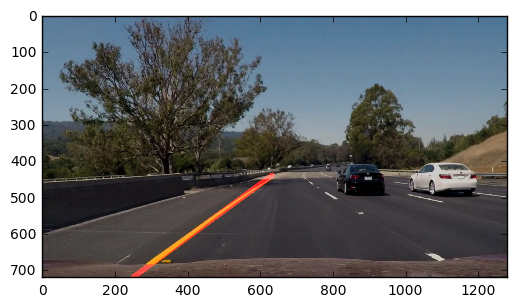

In [8]:
image =process_image('challenge_frame.jpg')
plt.figure()
plt.imshow(image)

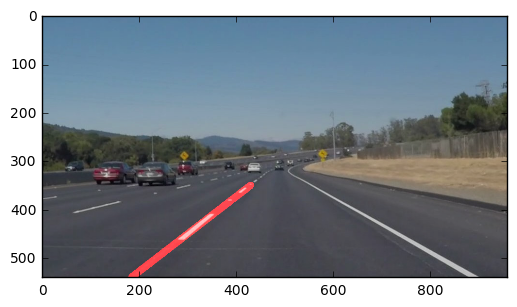

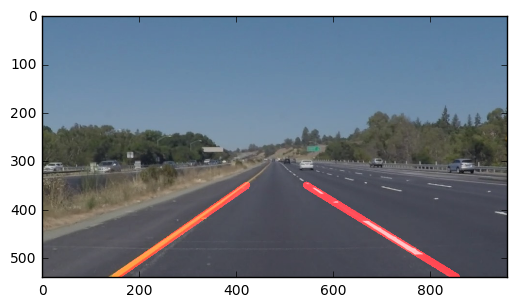

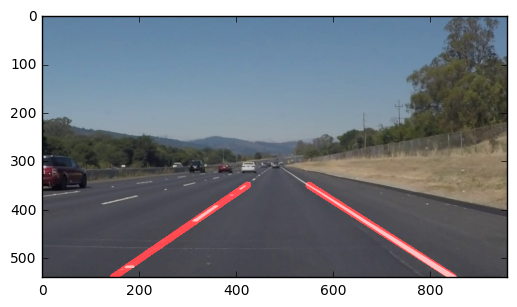

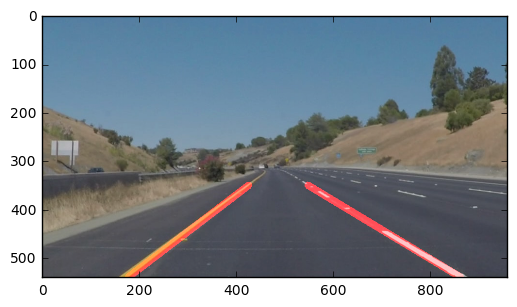

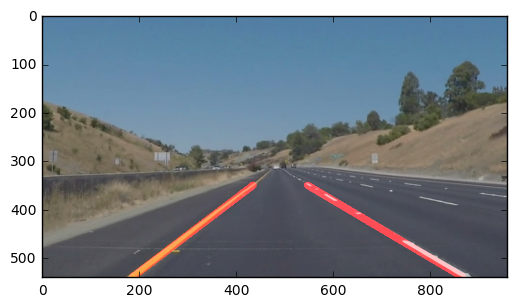

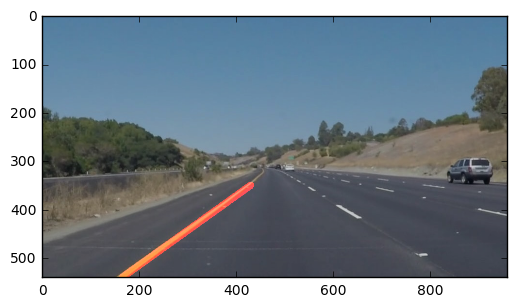

In [9]:
#'''Process the test images'''
processBatchImage("test_images/")

In [10]:

#'''Process The White Right video'''
HTML(process_video('white.mp4',"solidWhiteRight.mp4"))

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:15<00:00, 13.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.22 s, sys: 144 ms, total: 5.37 s
Wall time: 16.8 s


In [11]:
#'''Process The Yellow Left video'''
HTML(process_video('yellow.mp4',"solidYellowLeft.mp4"))


[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:50<00:00, 12.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 16.3 s, sys: 448 ms, total: 16.7 s
Wall time: 51.5 s


In [ ]:
HTML(process_video('extra.mp4',"challenge.mp4"))

# Reflections

I've tryed two different ways to built two kind of pipelines :
1/RGB to Gray oriented pipeline
2/Color selection oriented pipeline.

Recall that each pipeline has to answer the following requirements :
1/annotate the raw lane lines (left and right). The result should be an output images or videos almost same as the line-segments-example.jpg
2/fully annotate the lane line (left and right). The result should be an output images or videos almost same as the P1_example

1/RGB to Gray oriented pipeline   (findLaneLines_seglines.ipynb)
-------------------------------
It contains the following steps :
*/load Imge or video 
*/convert the loaded media from color space (RGB) to Gray. With 8-bits matrix, it makes the next steps easy to process the media
*/Apply ROI (region of interest) to keep only the region in front of driver which focuses only on the lane lines
*/Apply gaussian blur to smooth the pixels of the image
*/Apply canny edge detector 
*/Apply hough transform to detect lines
*/Draw lines detected by hough transform
*/Add the drawn lines to the original image

Implementation details:
-----------------------
Need to tweak the bluring kernel, the canny edge thresholds and hough transform parameters (threshold, min line length ...)

Results :
----------
Pros : Simple and easy to answer the first requirement (raw lane lines)
Cons : 
*/failed to answer the annotate the fully lane lines
*/failed to answer the challenge video with so many lines corresponding to trees, road horizontal lines sometimes, the guard rails ...

Enhancements : The dashed lines are rendred on video with a blinking effect.


2/Color selection oriented pipeline: (findLaneLines.ipynb)
------------------------------------
It contains the following steps :
*/load Imge or video 
*/Convert the color space from RGB to HSV 
*/create a first image based on the white color selection from the original one
*/create a second image based on the yellow color selection from the original one
*/add white and yellow image 
*/Apply ROI (region of interest) to keep only the region in front of driver which focuses only on the lane lines
*/Apply canny edge detector 
*/Apply hough transform to detect lines
*/Draw lines detected by hough transform
*/Add the drawn lines to the original image with details focused mainly on the lines
*/Apply canny edge detector with better resolution 
*/Apply hough transform to detect lines
*/Group left lane lines and right lane lines by slope or angle (negative are right and positive are left)
*/Average each group lines to obtain one line by group
*/Extrapolate each line by : 
    */calculating its slope and intercept first. 
    */calculating the intersection points with bottom and top of the ROI (region of interest)
    */Extend the line end points to intersection points
*/Draw the lane lines 
*/Add the drawn lines to the original image

Implementation details:
-----------------------
Need to tweak the color selection interval, the bluring kernel, the canny edge thresholds and hough transform parameters (threshold, min line length ...), the ROI coordinates

Results :
----------
Pros : Simple and easy to answer the first requirement (raw lane lines) and the second requirement
Accurate when rendering the lines on the image
Address the challenge video with accuracy

Enhancements : The dashed lines are rendred on video with a blinking effect.




In [12]:
#'''Process The Challenge video'''
HTML(process_video('extra.mp4',"challenge.mp4"))

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:35<00:00,  7.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 9.47 s, sys: 620 ms, total: 10.1 s
Wall time: 38.3 s
